# Brain MRI - Image Segmentation
------

In [1]:
import os
import PIL
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torchvision.transforms.functional as F
from torchvision import transforms as transforms
import torch.nn as nn
import torch
from torchsummary import summary

from imgseg import show, plot_random_masked_images, plot_one_image_mask
from imgseg import DoubleConvLayer, UNet4, UNet3
from imgseg import get_dataloader, SegmentationDataset
from imgseg import TrainingInterface, DiceLoss

## Create Folder, Organize Data

In [2]:
if not os.path.isdir('./kaggle_3m/images'):
    os.mkdir('./kaggle_3m/images')
if not os.path.isdir('./kaggle_3m/masks'):
    os.mkdir('./kaggle_3m/masks')

In [3]:
all_images = []
def unpack_folder(path: str):
    """Unpacks folder recusrively and appends to global list."""
    files = os.listdir(path)
    for f in files:
        if '.tif' in f:
            all_images.append(os.path.join(path, f))
        elif os.path.isdir(os.path.join(path, f)):
            unpack_folder(os.path.join(path, f)) 

In [4]:
unpack_folder('kaggle_3m/')
all_images[:5]

['kaggle_3m/images/TCGA_CS_4941_19960909_1.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_10.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_11.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_12.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_13.tif']

In [5]:
REPLACE_FILES = False
new_path_images = './kaggle_3m/images/'
new_path_masks = './kaggle_3m/masks/'

if REPLACE_FILES:
    for file in tqdm(all_images):
        img = Image.open(file)
        name = os.path.split(file)[-1]
        if 'mask' in name and name not in os.listdir(new_path_masks):
            img.save(os.path.join(new_path_masks, name))
        elif name not in os.listdir(new_path_images):
            img.save(os.path.join(new_path_images, name))

In [6]:
# build pandas dataset linking each mask with the real image
all_images = os.listdir(new_path_images)
all_masks = os.listdir(new_path_masks)
identifier = [img.split('.')[0] for img in all_images]

In [7]:
df_images = pd.DataFrame({'identifier': identifier, 'image': all_images})
df_masks = pd.DataFrame({'mask':all_masks})
df_masks['identifier'] = df_masks['mask'].apply(lambda x: x.split('_mask.tif')[0])
df = pd.merge(left=df_images, right=df_masks, on='identifier', how='inner')
df['patient_key'] = df['identifier'].apply(lambda x: '_'.join(x.split('_')[:-2]))

df.head(2)

,identifier,image,mask,patient_key
0,TCGA_CS_4941_19960909_1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,TCGA_CS_4941
1,TCGA_CS_4941_19960909_10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,TCGA_CS_4941


In [8]:
assert df.isnull().sum().sum() == 0

## Visualize Scans with Masks

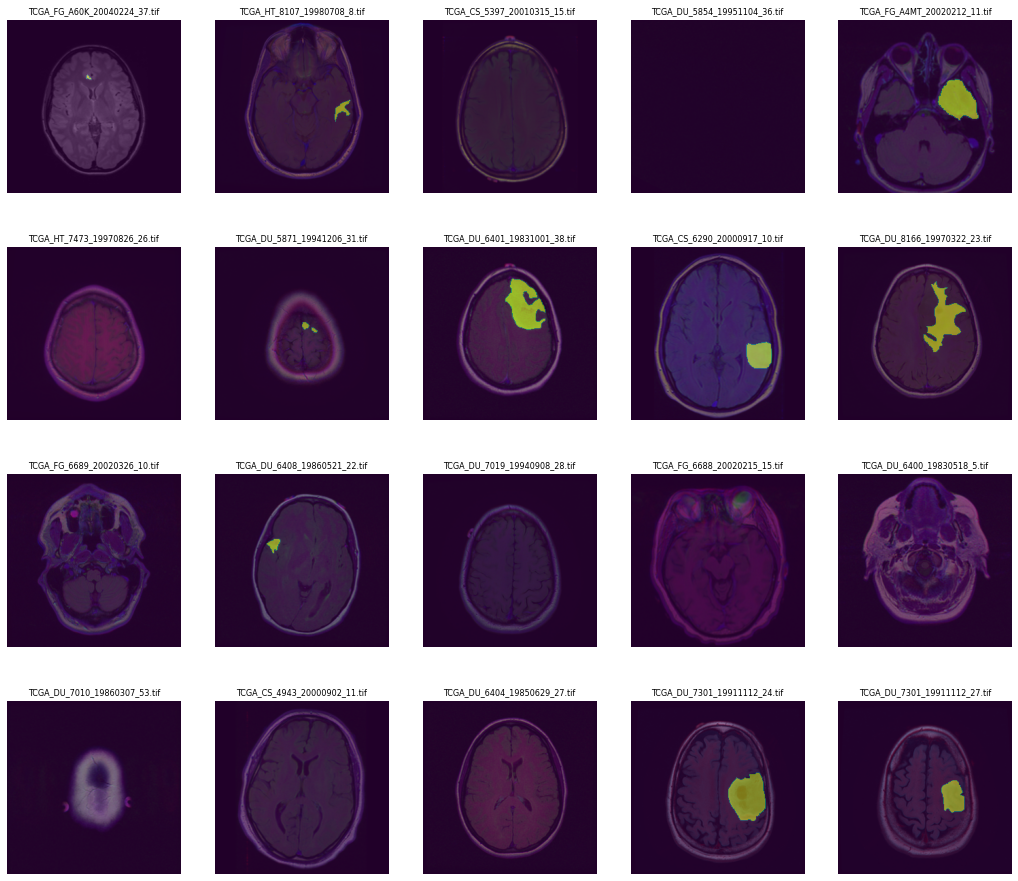

In [9]:
plot_random_masked_images(df, 20)

### Hwo does an image look without a proper mask?

In [10]:
def plot_one_image_mask(df: pd.DataFrame, img_name: str, path_masks: str = './kaggle_3m/masks/', 
                        path_images: str = './kaggle_3m/images/'):
    
    img_mask = df.loc[df['image'] == img_name, 'mask'].values[0]
    fig, ax = plt.subplots(figsize=(10, 4))
    plt.subplot(1,3,1)
    plt.imshow(PIL.Image.open(os.path.join(path_images, img_name)))
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(PIL.Image.open(os.path.join(path_masks, img_mask)))
    plt.title('Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(PIL.Image.open(os.path.join(path_images, img_name)))
    plt.imshow(PIL.Image.open(os.path.join(path_masks, img_mask)), alpha=.3)
    plt.title('Image + Mask')
    plt.axis('off')
    
    plt.show()

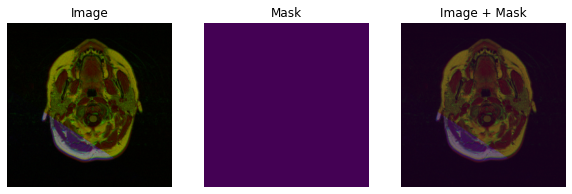

In [11]:
plot_one_image_mask(df, 'TCGA_FG_7643_20021104_3.tif')

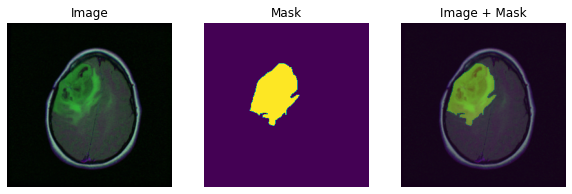

In [44]:
plot_one_image_mask(df, 'TCGA_DU_6408_19860521_36.tif')

In [12]:
PREPARE_DF = False

if PREPARE_DF:
    def make_mask_label(img_path):
        img_path = os.path.join('./kaggle_3m/masks/', img_path)
        img = np.asarray(PIL.Image.open(img_path))
        return True if img.sum() > 0 else False 
    
    df['has_segment_mask'] = df['mask'].apply(make_mask_label)
    
    if SAVE_DF:
        df.to_csv('./kaggle_3m/image_data.csv', index=False)
        
else:
    df = pd.read_csv('./kaggle_3m/image_data.csv')

In [13]:
df.head(2)

,identifier,image,mask,patient_key,has_segment_mask,set
0,TCGA_FG_A4MT_20020212_15,TCGA_FG_A4MT_20020212_15.tif,TCGA_FG_A4MT_20020212_15_mask.tif,TCGA_FG_A4MT,True,train
1,TCGA_DU_6407_19860514_30,TCGA_DU_6407_19860514_30.tif,TCGA_DU_6407_19860514_30_mask.tif,TCGA_DU_6407,True,train


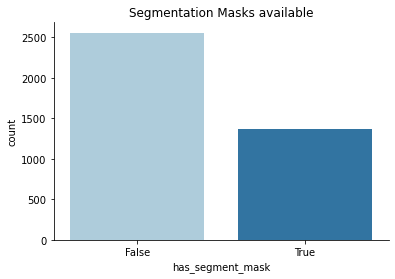

In [14]:
p = sns.countplot(x=df['has_segment_mask'], palette='Paired')
p.set_title('Segmentation Masks available')
sns.despine()
plt.show()

**Beschreibung:**

In [15]:
df.head(2)

,identifier,image,mask,patient_key,has_segment_mask,set
0,TCGA_FG_A4MT_20020212_15,TCGA_FG_A4MT_20020212_15.tif,TCGA_FG_A4MT_20020212_15_mask.tif,TCGA_FG_A4MT,True,train
1,TCGA_DU_6407_19860514_30,TCGA_DU_6407_19860514_30.tif,TCGA_DU_6407_19860514_30_mask.tif,TCGA_DU_6407,True,train


In [16]:
BUILD_SET = False

if BUILD_SET:
    train, test = train_test_split(df, test_size=.1, random_state=10, stratify=df['has_segment_mask'])
    val, test = train_test_split(test, test_size=.5, random_state=10, stratify=test['has_segment_mask'])
    train['set'] = 'train'
    val['set'] = 'val'
    test['set'] = 'test'
    df = pd.concat([train, val, test], axis=0)
    df.to_csv('./kaggle_3m/image_data.csv', index=False)

In [17]:
# image dim
PIL.Image.open(os.path.join(new_path_images, 
                            df.loc[0, 'image'])).size

(256, 256)

## Build Model, Implementation of U-Net

In [18]:
summary(DoubleConvLayer(1, 64), input_size=(1, 572, 572), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 572, 572]             640
       BatchNorm2d-2         [-1, 64, 572, 572]             128
              ReLU-3         [-1, 64, 572, 572]               0
            Conv2d-4         [-1, 64, 572, 572]          36,928
       BatchNorm2d-5         [-1, 64, 572, 572]             128
              ReLU-6         [-1, 64, 572, 572]               0
Total params: 37,824
Trainable params: 37,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.25
Forward/backward pass size (MB): 958.55
Params size (MB): 0.14
Estimated Total Size (MB): 959.94
----------------------------------------------------------------


In [19]:
summary(UNet3(in_channels=1, out_channels=1), input_size=(1, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
   DoubleConvLayer-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [20]:
image, mask = df.loc[0, ['image', 'mask']].values

In [21]:
image, mask

('TCGA_FG_A4MT_20020212_15.tif', 'TCGA_FG_A4MT_20020212_15_mask.tif')

## Setup Dataloader

In [22]:
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(256, 256)),
    transforms.RandAugment(num_ops=2, magnitude=6),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(1., 1., 1.), std=(.5, .5, .5))
])

image_transforms_inference = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(1., 1., 1.), std=(.5, .5, .5))
])

inverse_image_transforms = transforms.Compose([
    transforms.Normalize(mean=(0, 0, 0), std=(1/.5, 1/.5, 1/.5)),
    #transforms.Normalize(mean=(-1, -1, -1), std=(1, 1, 1))
])

In [23]:
dataloader = get_dataloader(image_dir='./kaggle_3m/images/', 
                            mask_dir='./kaggle_3m/masks/', 
                            df=pd.read_csv('./kaggle_3m/image_data.csv'), 
                            transformations=image_transforms,
                            batch_size=1, workers=1,)

In [24]:
img, seg = next(iter(dataloader))

In [25]:
img.shape, seg.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]))

## Model Training

In [39]:
df = pd.read_csv('./kaggle_3m/image_data.csv')
df.sample(2)

,identifier,image,mask,patient_key,has_segment_mask,set
2073,TCGA_DU_5871_19941206_24,TCGA_DU_5871_19941206_24.tif,TCGA_DU_5871_19941206_24_mask.tif,TCGA_DU_5871,True,train
128,TCGA_HT_8563_19981209_23,TCGA_HT_8563_19981209_23.tif,TCGA_HT_8563_19981209_23_mask.tif,TCGA_HT_8563,False,train


In [ ]:
# Compute class weights for sampler
classes =  np.unique(df['has_segment_mask'])
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=classes, 
                                     y=df['has_segment_mask'])
weights_replace_with = dict(zip(classes, class_weights))
df['class_weight'] = df['has_segment_mask'].replace(weights_replace_with)
df.head(2)

In [40]:
train = df[df['set'] == 'train'].reset_index(drop=True)
val = df[df['set'] == 'val'].reset_index(drop=True)
test = df[df['set'] == 'test'].reset_index(drop=True)

sampler = WeightedRandomSampler(weights=train['class_weight'].to_numpy(),
                                num_samples=train.shape[0], 
                                replacement=True)

dataloader_train = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/', 
                                  df=train,
                                  transformations=image_transforms,
                                  batch_size=8, workers=1,
                                  sampler=sampler)

dataloader_val = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/', 
                                df=val,
                                transformations=image_transforms_inference,
                                batch_size=8, workers=1,)

dataloader_test = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/',
                                  df=test,
                                  transformations=image_transforms_inference,
                                  batch_size=8, workers=1)

In [41]:
unet = UNet3(in_channels=1, out_channels=1)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(params=unet.parameters(), lr=.0001, momentum=.5)

In [42]:
interface = TrainingInterface(model=unet, name='Unet3')

In [ ]:
interface.train(
    criterion=criterion,
    optimizer=optimizer, 
    n_epochs=3, 
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    verbose=True
)

In [ ]:
y_true, y_pred, images = interface.segment(dataloader=dataloader_test, return_images=True)

In [ ]:
for idx in range(0, 20):
    PLOT_ID = idx
    true_mask = inverse_image_transforms(y_true[PLOT_ID])
    pred_mask = inverse_image_transforms(y_pred[PLOT_ID])
    image = inverse_image_transforms(images[PLOT_ID])

    fig, ax = plt.subplots(figsize=(15, 4))

    plt.subplot(1,3,1)
    plt.imshow(image, cmap='Greys_r')
    plt.subplot(1,3,2)
    plt.imshow(true_mask)
    plt.subplot(1,3,3)
    plt.imshow(pred_mask)

    plt.show()

## Sources

different loss: https://www.codetd.com/en/article/9915075